# Convolution Network
- Data : Fashion_mnist Dataset
- Label Info
    - 0 : T-Shirt
    - 1 : Trouser
    - 2 : Pullover
    - 3 : Dress
    - 4 : Coat
    - 5 : Sandal
    - 6 : Shirt
    - 7 : Sneaker
    - 8 : Bag
    - 9 : Ankle Boot

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

## Load Dataset

In [2]:
train_dataset = torchvision.datasets.FashionMNIST("./data_03", download=True,
                                                 transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("./data_03", download=True,
                                                train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
print(train_dataset)
print(train_dataset[0][0].shape)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data_03
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
torch.Size([1, 28, 28])


In [4]:
# data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

## Data Exploration
- train data 확인

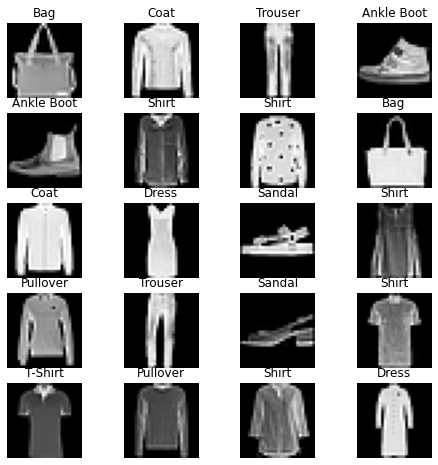

In [5]:
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress',
             4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker',
             8: 'Bag', 9: 'Ankle Boot'}

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0, :, :]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

## Modeling

In [6]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

## One GPU vs Multiplie GPU

In [7]:
# 단일 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = FashionDNN()
# model.to(device)

# multiple gpu
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = FashionDNN()
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)
# model.to(device)

print(device)

cuda:0


## Loss Funciton, Learning rate, Optimizer

In [8]:
lr = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


## Training

In [9]:
%%time
# One GPU
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}%")

Iteration: 500, Loss: 0.6911495327949524, Accuracy: 83.33999633789062%
Iteration: 1000, Loss: 0.4550672769546509, Accuracy: 84.72999572753906%
Iteration: 1500, Loss: 0.3572482764720917, Accuracy: 84.48999786376953%
Iteration: 2000, Loss: 0.3593442440032959, Accuracy: 85.97999572753906%
Iteration: 2500, Loss: 0.27280259132385254, Accuracy: 85.75999450683594%
Iteration: 3000, Loss: 0.2409103363752365, Accuracy: 86.43000030517578%
CPU times: user 1min 3s, sys: 2.27 s, total: 1min 5s
Wall time: 1min 5s


In [10]:
# multiple gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionDNN()
if torch.cuda.device_count() > 1:
    print(torch.cuda.device_count())
    model = nn.DataParallel(model)
model.to(device)

print(device)

4
cuda


In [11]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model)

DataParallel(
  (module): FashionDNN(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [12]:
%%time
# Multiple GPU
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print(f"Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}%")

Iteration: 500, Loss: 2.702517032623291, Accuracy: 27.670000076293945%
Iteration: 1000, Loss: 1.8600469827651978, Accuracy: 28.209999084472656%
Iteration: 1500, Loss: 3.5071029663085938, Accuracy: 28.0%
Iteration: 2000, Loss: 2.755603551864624, Accuracy: 28.619998931884766%
Iteration: 2500, Loss: 2.305391311645508, Accuracy: 28.469999313354492%
Iteration: 3000, Loss: 1.8254529237747192, Accuracy: 28.639999389648438%
CPU times: user 1min 31s, sys: 4.88 s, total: 1min 35s
Wall time: 1min 27s


In [13]:
# test